In [2]:
from models.PINN import *
import matplotlib.pyplot as plt
import torch.utils.data as data
import numpy as np
import time
from mpl_toolkits.mplot3d import Axes3D

In [3]:
dt = 0.01
t_0 = 0.
t_f = 10.

t = torch.linspace(t_0, t_f, int(t_f/dt))
t= t.reshape((len(t), 1))
x_0 = torch.tensor([0., -1., 9.])
x_f =torch.tensor([5., 7., -3])
layers = [1, 50, 50, 3]
loss_arr = []
steps=50000
lr=0.001



epoch: 100.00000, total loss: 21.83773, data loss: 19.61510, pde loss: 0.44453, KE: -0.00012, PE: 0.03887
epoch: 200.00000, total loss: 2.48390, data loss: 2.19633, pde loss: 0.05751, KE: -0.09195, PE: 0.10114
epoch: 300.00000, total loss: 0.14357, data loss: 0.03610, pde loss: 0.02149, KE: -0.16946, PE: 0.16920
epoch: 400.00000, total loss: 0.02194, data loss: 0.00403, pde loss: 0.00358, KE: -0.18296, PE: 0.18085
epoch: 500.00000, total loss: 0.00523, data loss: 0.00073, pde loss: 0.00090, KE: -0.18530, PE: 0.18349
epoch: 600.00000, total loss: 0.00335, data loss: 0.00042, pde loss: 0.00059, KE: -0.18524, PE: 0.18367
epoch: 700.00000, total loss: 0.00283, data loss: 0.00037, pde loss: 0.00049, KE: -0.18470, PE: 0.18328
epoch: 800.00000, total loss: 0.00250, data loss: 0.00036, pde loss: 0.00043, KE: -0.18411, PE: 0.18279
epoch: 900.00000, total loss: 0.00226, data loss: 0.00035, pde loss: 0.00038, KE: -0.18355, PE: 0.18231
epoch: 1000.00000, total loss: 0.00207, data loss: 0.00035, pd

KeyboardInterrupt: 

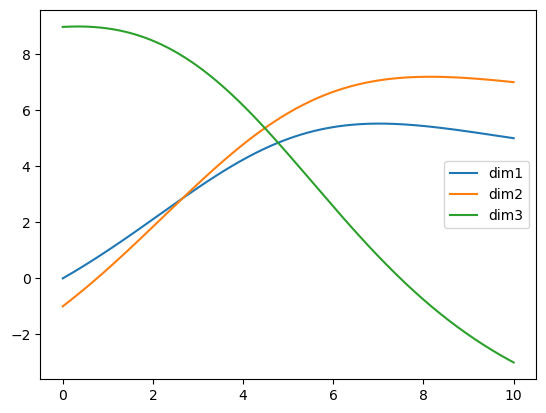

In [3]:
t_0, t_f = torch.tensor([t_0]), torch.tensor([t_f])
forward_model = PINN(layers, t_0, t_f)
params = list(forward_model.dnn.parameters())
optimizer = optim.Adam(params, lr=lr, eps=1e-08, betas = (0.8, 0.99), weight_decay=0, amsgrad=True)

for i in range(steps):
    optimizer.zero_grad()
    loss, loss_data, loss_ode, energy = forward_model.loss(t_0, t_f, x_0, x_f, t)
    loss.backward()
    optimizer.step()
    forward_model.iter+=1
    if forward_model.iter % 100 == 0:
        rollout = forward_model.dnn(t).clone().detach().numpy()
        KE = energy[0].mean()
        PE = energy[1].mean()
        plt.clf()
        plt.plot(t.clone().detach().numpy(), rollout[:, 0], label = 'dim1')
        plt.plot(t.clone().detach().numpy(), rollout[:, 1], label = 'dim2')
        plt.plot(t.clone().detach().numpy(), rollout[:, 2], label = 'dim3')
        plt.legend()
        plt.savefig('dynamics.png')
        print(
            'epoch: %.5f, total loss: %.5f, data loss: %.5f, pde loss: %.5f, KE: %.5f, PE: %.5f' %
            (
                forward_model.iter,
                loss, 
                loss_data, 
                loss_ode,
                KE, 
                PE
            )
        )



In [ ]:
du_dt = u_t
rhs = torch.zeros_like(du_dt[:, 0])
constraint = du_dt[:, 0] + du_dt[:, 1] + du_dt[:, 2]
du_dt

tensor([[[ 0.3973],
         [ 0.6757],
         [-0.9998]],

        [[ 0.3988],
         [ 0.6778],
         [-1.0037]],

        [[ 0.4003],
         [ 0.6799],
         [-1.0075]],

        ...,

        [[-0.0345],
         [ 0.0321],
         [ 0.0332]],

        [[-0.0361],
         [ 0.0298],
         [ 0.0369]],

        [[-0.0377],
         [ 0.0275],
         [ 0.0405]]], grad_fn=<StackBackward0>)

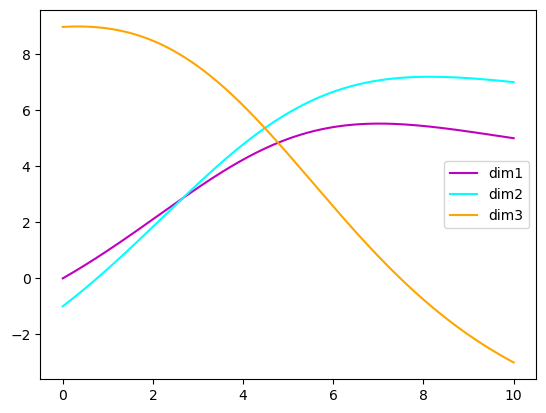

In [4]:
#u = forward_model.dnn(t).clone().detach().numpy()
#np.save('dumb_data2.npy', u)

u = np.load("dumb_data2.npy")
plt.clf()
plt.plot(t.clone().detach().numpy(), u[:, 0], c='m', label = 'dim1')
plt.plot(t.clone().detach().numpy(), u[:, 1], c='cyan', label = 'dim2')
plt.plot(t.clone().detach().numpy(), u[:, 2], c='orange', label = 'dim3')
plt.legend()
plt.show()

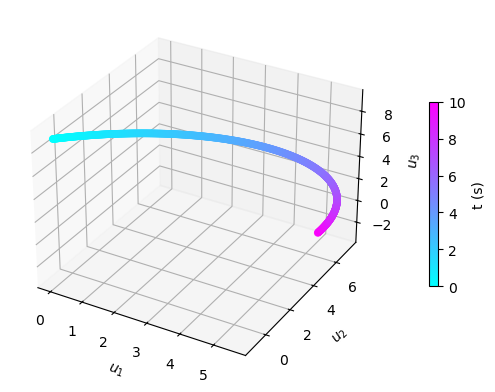

In [5]:
# Set up the figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D, color by time
sc = ax.scatter(u[:, 0], u[:, 1], u[:, 2], c=t.clone().detach().numpy(), cmap='cool')

# Add colorbar to indicate the time value
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, pad=0.1)
cbar.set_label('t (s)')

# Set labels for the axes
ax.set_xlabel('$u_1$')
ax.set_ylabel('$u_2$')
ax.set_zlabel('$u_3$')
plt.savefig('latent_rep.png', transparent=True)
# Show the plot
plt.show()


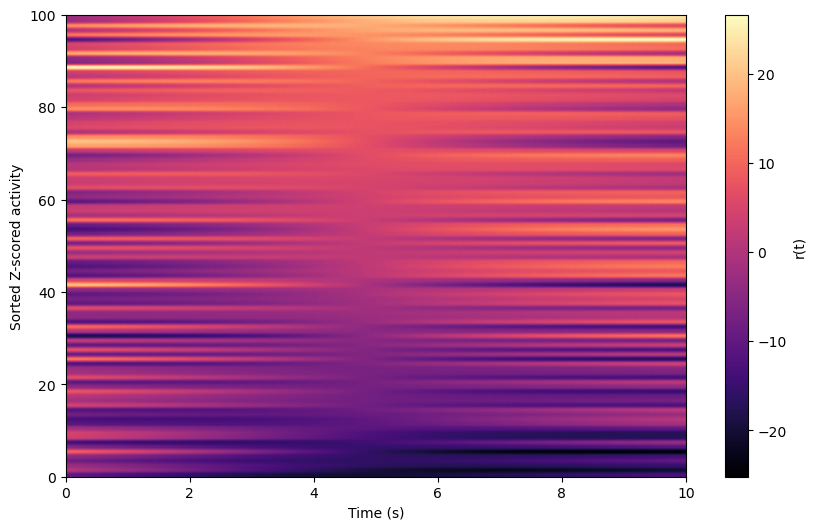

In [6]:
projection_matrix = np.random.randn(3, 100)

data = np.dot(u, projection_matrix)
data += + np.random.normal(0, 0.1, data.shape)
np.save('/home/rdkeller/latentphysics/dumb_data_full.npy', data)
#np.save('/home/rdkeller/latentphysics/data/' + 'HD_data.npy', data)
mean_activity = np.mean(data, axis=0)

# Step 2: Sort neurons by their mean activity
sorted_indices = np.argsort(mean_activity)

# Step 3: Sort the data according to the sorted neuron indices
sorted_data = data[:, sorted_indices]

# Step 4: Create the plot
plt.figure(figsize=(10, 6))
plt.imshow(sorted_data.T, aspect='auto', cmap='magma', origin='lower', extent=[0, 10, 0, 100])
plt.colorbar(label='r(t)')
# Step 5: Customize the plot
plt.xlabel('Time (s)')
plt.ylabel('Sorted Z-scored activity')
plt.xticks([0, 2, 4, 6, 8, 10])  # Adjust based on time range
plt.savefig('raster.png', transparent=True)

# Show the plot

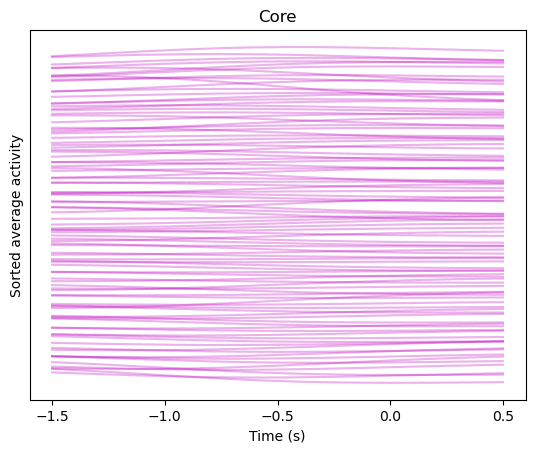

In [50]:
time = np.linspace(-1.5, 0.5, sorted_data.shape[0])  # Assuming the time is from -1.5 to 0.5 seconds

for i in range(100):
    plt.plot(time, sorted_data[:, i] + i * 6, color='m', alpha=0.3)  # Add vertical offset for each trace

# Step 6: Customize the plot
plt.title('Core')
plt.xlabel('Time (s)')
plt.ylabel('Sorted average activity')
plt.xticks([-1.5, -1, -0.5, 0, 0.5])  # Adjust based on time range
plt.yticks([])  # Hide y-ticks since we're plotting individual traces with offsets

plt.show()